In [29]:
!pip install torchvggish
!pip install resampy  # required for VGGish preprocessing
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchvggish import vggish, vggish_input
import torch.nn.functional as F
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split

In [2]:
#Load Data
df = pd.read_csv('/content/drive/MyDrive/multimodal_dataset_normalized.csv')
display(df.head())

,Audio_Song,Lyric_Song,Arousal,Valence,Quadrant,Emotion,lyric_id,word_count,unique_word_count,lexical_diversity,...,rms_mean,rms_std,beat_strength,low_energy_ratio,energy_entropy,brightness,warmth,activity,harmonic_energy_ratio,harmonicity
0,A005,L055,0.78750,0.68750,Q1,Excited,L055,0.583846,-0.032136,-1.136493,...,-1.315662,-1.165455,0.896397,-0.700513,-0.145042,1.086334,-0.092941,[0.06471955],-1.951364,-0.583475
1,A011,L061,0.68125,0.85625,Q1,Happy,L061,-0.549140,-0.974930,-1.286263,...,0.107522,-0.408386,0.006682,0.068631,0.750471,0.147696,0.040220,[0.18521025],0.472448,-0.078961
2,A014,L064,0.86250,0.72500,Q1,Excited,L064,0.415581,-0.162177,-1.133997,...,0.361195,-0.265328,0.710477,-0.673247,0.854382,1.970159,-0.798261,[0.17745368],-0.949336,-0.454885
3,A019,L069,0.78125,0.81875,Q1,Happy,L069,-0.229436,-0.308472,-0.401603,...,-0.219121,-0.979168,-0.061622,-0.340510,1.062094,0.474343,0.110013,[0.13742129],0.244760,-0.150335
4,A022,L072,0.76875,0.83750,Q1,Happy,L072,-0.599619,-0.828634,-0.755787,...,0.916902,0.959027,-0.008507,-0.482841,0.298920,-0.169472,0.269772,[0.22606403],-0.078616,-0.234134


In [3]:
#Emotion Class
unique_items = df["Quadrant"].unique()
print(unique_items)

['Q1' 'Q2' 'Q3' 'Q4']


In [4]:
#Extract path and emotion
data_dir = "/content/drive/MyDrive/audio"
labels_dict = {f"{row['Quadrant']}/{row['Audio_Song']}.mp3": row['Quadrant']
               for _, row in df.iterrows()}
print(labels_dict)

{'Q1/A005.mp3': 'Q1', 'Q1/A011.mp3': 'Q1', 'Q1/A014.mp3': 'Q1', 'Q1/A019.mp3': 'Q1', 'Q1/A022.mp3': 'Q1', 'Q1/A024.mp3': 'Q1', 'Q1/A039.mp3': 'Q1', 'Q1/A042.mp3': 'Q1', 'Q1/A043.mp3': 'Q1', 'Q1/A047.mp3': 'Q1', 'Q1/A050.mp3': 'Q1', 'Q1/A064-116.mp3': 'Q1', 'Q1/A077-122.mp3': 'Q1', 'Q1/A086-123.mp3': 'Q1', 'Q1/A092-96.mp3': 'Q1', 'Q1/A094-110.mp3': 'Q1', 'Q1/A095-113.mp3': 'Q1', 'Q1/A100-124.mp3': 'Q1', 'Q1/A101-111.mp3': 'Q1', 'Q1/A102-114.mp3': 'Q1', 'Q1/A104-119.mp3': 'Q1', 'Q1/A105-117.mp3': 'Q1', 'Q1/A107-115.mp3': 'Q1', 'Q1/A114-120.mp3': 'Q1', 'Q1/A115-84.mp3': 'Q1', 'Q1/A128-109.mp3': 'Q1', 'Q1/A132-121.mp3': 'Q1', 'Q1/A146-118.mp3': 'Q1', 'Q1/A148-102.mp3': 'Q1', 'Q1/A152-108.mp3': 'Q1', 'Q1/A153-130.mp3': 'Q1', 'Q1/A160-149.mp3': 'Q1', 'Q1/A162.mp3': 'Q1', 'Q1/A166.mp3': 'Q1', 'Q1/A167.mp3': 'Q1', 'Q1/A187.mp3': 'Q1', 'Q1/A196.mp3': 'Q1', 'Q1/MT0000040773.mp3': 'Q1', 'Q1/MT0000045345.mp3': 'Q1', 'Q1/MT0000080053.mp3': 'Q1', 'Q1/MT0000091401.mp3': 'Q1', 'Q1/MT0000093583.mp3': '

In [5]:
#Settings
duration = 30
sr = 16000
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data Preprocessing
X_list = []
y_list = []


target_frames = 1876
all_classes = ['Q1', 'Q2', 'Q3', 'Q4']
class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
print("Class to index mapping:", class_to_idx)


for file, label in labels_dict.items():
    filepath = os.path.join(data_dir, file)
    y, _ = librosa.load(filepath, sr=sr, duration=duration)

    # VGGish preprocessing: convert waveform to log-mel spectrogram
    mel = vggish_input.waveform_to_examples(y, sr)

    # mel shape: (num_patches, 1, 96, 64)
    mel_tensor = torch.tensor(mel, dtype=torch.float32)

    # Average over patches to get single embedding per clip
    mel_tensor = mel_tensor.mean(dim=0, keepdim=True)  # shape: (1, 1, 96, 64)

    X_list.append(mel_tensor)
    y_list.append(class_to_idx[label])

X = torch.cat(X_list, dim=0)  # shape: (N, 1, 96, 64)
y = torch.tensor(y_list, dtype=torch.long)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Class to index mapping: {'Q1': 0, 'Q2': 1, 'Q3': 2, 'Q4': 3}


/tmp/ipython-input-1497987939.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_tensor = torch.tensor(mel, dtype=torch.float32)


Train shape: torch.Size([1329, 1, 96, 64]) torch.Size([1329])
Val shape: torch.Size([443, 1, 96, 64]) torch.Size([443])
Test shape: torch.Size([444, 1, 96, 64]) torch.Size([444])


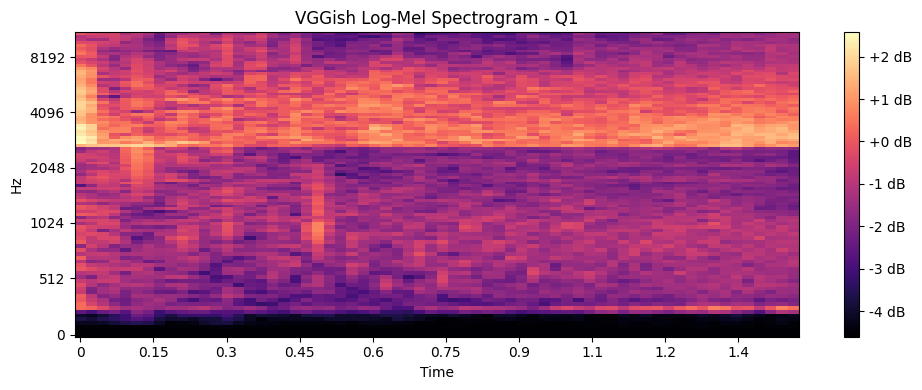

In [6]:
# Take the first audio clip
file, label = list(labels_dict.items())[0]
filepath = os.path.join(data_dir, file)
y, _ = librosa.load(filepath, sr=16000, duration=duration)

# Convert waveform to VGGish log-mel spectrogram
mel_patches = vggish_input.waveform_to_examples(y, sr)  # (num_patches, 1, 96, 64)

# Pick the first patch for visualization
mel_example = mel_patches[0, 0, :, :]  # (96, 64)

# Detach and convert to NumPy
if isinstance(mel_example, torch.Tensor):
    mel_example = mel_example.detach().numpy()

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_example, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"VGGish Log-Mel Spectrogram - {label}")
plt.tight_layout()
plt.show()

In [59]:
# Load pretrained VGGish model
vgg_model = vggish()
vgg_model.to(device)

# Move PCA parameters to the same device as the model
if hasattr(vgg_model.pproc, '_pca_matrix') and isinstance(vgg_model.pproc._pca_matrix, torch.Tensor):
    vgg_model.pproc._pca_matrix = vgg_model.pproc._pca_matrix.to(device)
if hasattr(vgg_model.pproc, '_pca_means') and isinstance(vgg_model.pproc._pca_means, torch.Tensor):
    vgg_model.pproc._pca_means = vgg_model.pproc._pca_means.to(device)

# Get all parameter groups (ordered from first to last layer)
all_vgg_params = list(vgg_model.parameters())
total_param_groups = len(all_vgg_params)

# Each layer has 2 parameter groups: weights + biases
# To unfreeze the LAST layer, target the final 2 parameter groups
if total_param_groups >= 2:
    # Freeze all layers first
    for param in vgg_model.parameters():
        param.requires_grad = False

    # Unfreeze the last 2 parameter groups (last layer's weights and biases)
    for param in all_vgg_params[-2:]:  # [-2:] selects the last 2 groups
        param.requires_grad = True

    # Verify
    trainable_count = sum(1 for param in vgg_model.parameters() if param.requires_grad)
    print(f"Unfroze {trainable_count} parameter groups (last layer of VGGish)")
else:
    print("Warning: VGGish model has fewer parameter groups than expected.")

# Add FC classifier for emotions
fc_model = nn.Sequential(
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, num_classes)  # num_classes should be defined (e.g., 3 for 3 emotions)
).to(device)

Unfroze 2 parameter groups (last layer of VGGish)


In [66]:
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Loss function and optimizer (includes both VGGish unfrozen layers and FC model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    list(vgg_model.parameters()) + list(fc_model.parameters()),
    lr=1e-3
)

num_epochs = 5

for epoch in range(num_epochs):
    # Training
    vgg_model.train()
    fc_model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Get embeddings from VGGish
        embeddings = vgg_model(X_batch)  # shape: (batch, 128)

        # Ensure proper dimensions
        if embeddings.ndim == 1:
            embeddings = embeddings.unsqueeze(0)
        elif embeddings.ndim > 2:
            embeddings = embeddings.view(-1, 128)

        # Forward pass through classifier
        logits = fc_model(embeddings)
        loss = criterion(logits, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(logits, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    vgg_model.eval()
    fc_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            embeddings = vgg_model(X_batch)
            logits = fc_model(embeddings)
            loss = criterion(logits, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(logits, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/5 | Train Loss: 1.0563, Train Acc: 0.4658 | Val Loss: 0.9808, Val Acc: 0.5056
Epoch 2/5 | Train Loss: 1.0333, Train Acc: 0.4755 | Val Loss: 0.9693, Val Acc: 0.5711
Epoch 3/5 | Train Loss: 1.0320, Train Acc: 0.4673 | Val Loss: 0.9716, Val Acc: 0.5395
Epoch 4/5 | Train Loss: 1.0248, Train Acc: 0.4733 | Val Loss: 0.9910, Val Acc: 0.5260
Epoch 5/5 | Train Loss: 1.0394, Train Acc: 0.4740 | Val Loss: 0.9926, Val Acc: 0.5124


In [67]:
# Testing with best model

vgg_model.eval()
fc_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        embeddings = vgg_model(X_batch)
        if embeddings.ndim == 1:
            embeddings = embeddings.unsqueeze(0)
        elif embeddings.ndim > 2:
            embeddings = embeddings.view(-1, 128)

        logits = fc_model(embeddings)
        _, predicted = torch.max(logits, 1)

        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.5360
